In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install pyarrow
!pip install pygam
!pip install shap

## Imports

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import gc
import math
import re

from tqdm import tqdm
from collections import Counter

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score

import lightgbm as lgb
from pygam import LogisticGAM
import xgboost as xgb

import shap  # package used to calculate Shap values

import warnings
warnings.simplefilter(action='ignore')

# change to path
PATH='/content/drive/My Drive/Colab Notebooks/grab/'
os.chdir(PATH)

In [0]:
PATH_LABELS = PATH + 'safety/labels'
PATH_FEATURES = PATH + 'safety/features'

## Read in
Start working from the aggregated dataframe produced from `preprocess`.

In [5]:
train_df = pd.read_feather(f'{PATH_FEATURES}/agg_train-5')

# # UNCOMMENT
# test_df = pd.read_feather(f'{PATH_FEATURES}/agg_test')

train_df.head()

,bookingID,acceleration_x_max,acceleration_x_min,acceleration_x_median,acceleration_x_std,acceleration_x_percentile,acceleration_y_max,acceleration_y_min,acceleration_y_median,acceleration_y_std,acceleration_y_percentile,acceleration_z_max,acceleration_z_min,acceleration_z_median,acceleration_z_std,acceleration_z_percentile,gyro_x_max,gyro_x_min,gyro_x_median,gyro_x_std,gyro_x_percentile,gyro_y_max,gyro_y_min,gyro_y_median,gyro_y_std,gyro_y_percentile,gyro_z_max,gyro_z_min,gyro_z_median,gyro_z_std,gyro_z_percentile,Speed_max,Speed_min,Speed_median,Speed_std,Speed_percentile,total_a_max,total_a_min,total_a_median,total_a_std,...,acceleration_y_sign_change,acceleration_z_fo_min,acceleration_z_fo_max,acceleration_z_so_min,acceleration_z_so_max,acceleration_z_sign_change,gyro_x_fo_min,gyro_x_fo_max,gyro_x_so_min,gyro_x_so_max,gyro_x_sign_change,gyro_y_fo_min,gyro_y_fo_max,gyro_y_so_min,gyro_y_so_max,gyro_y_sign_change,gyro_z_fo_min,gyro_z_fo_max,gyro_z_so_min,gyro_z_so_max,gyro_z_sign_change,roll_fo_min,roll_fo_max,roll_so_min,roll_so_max,roll_sign_change,pitch_fo_min,pitch_fo_max,pitch_so_min,pitch_so_max,pitch_sign_change,acceleration_x_count_above_2,acceleration_x_count_above_3,acceleration_y_count_above_2,acceleration_y_count_above_3,acceleration_z_count_above_2,acceleration_z_count_above_3,second_max,second_count,label
0,0,4.782614,-4.692294,-0.725250,0.928022,0.347582,-6.119916,-12.764703,-9.622127,0.639934,-8.936234,2.318857,-6.251807,-1.607663,1.141266,-0.210278,0.438371,-0.392537,0.002575,0.065954,0.083481,0.469724,-0.609930,-0.002239,0.100225,0.097003,0.372807,-0.731892,-0.003522,0.063685,0.061658,22.946083,-1.0,8.503366,7.199919,18.748623,12.988328,6.457339,9.852645,0.624159,...,0.0,5.173502,6.087766,9.125891,10.789780,128.0,0.525470,0.486405,0.972448,0.930134,491.0,0.629634,0.897888,1.315454,1.044398,452.0,0.568942,0.719506,0.698531,1.288449,486.0,0.601279,0.525920,0.929869,1.103402,0.0,0.565893,0.622762,0.912975,1.049871,251.0,77.0,17.0,1004.0,1004.0,309.0,101.0,1589.0,1004,0
1,1,3.813341,-5.352994,-0.563126,0.744157,0.059367,12.536156,6.623425,9.537963,0.533915,10.133488,1.481293,-5.355455,-2.175822,0.854271,-1.213190,0.126536,-0.125367,-0.001518,0.027740,0.029845,0.470837,-0.678183,-0.003491,0.091699,0.070302,0.235131,-0.121265,-0.000384,0.033838,0.040108,21.882141,-1.0,6.904588,7.059362,18.593060,12.790147,6.970526,9.844748,0.519956,...,0.0,4.126713,3.441799,7.568512,5.746438,20.0,0.173800,0.238639,0.403154,0.299289,454.0,0.352295,0.372715,0.388964,0.472042,361.0,0.231692,0.206280,0.340217,0.347914,409.0,0.347471,0.434247,0.486340,0.781718,0.0,0.308782,0.333688,0.397189,0.441969,104.0,32.0,7.0,851.0,851.0,546.0,115.0,1034.0,851,1
2,2,1.956122,-2.971295,0.433364,0.756589,1.145421,13.333716,7.941810,9.814133,0.505693,10.212540,2.312870,-3.282551,0.366324,1.020021,1.235446,0.282162,-0.155218,0.001164,0.053903,0.052843,0.431695,-0.462000,0.001035,0.117321,0.092787,0.255884,-0.125907,0.001764,0.036215,0.032063,9.360483,0.0,2.998761,2.897762,7.260158,13.403410,8.234988,9.877755,0.515173,...,0.0,4.683201,2.942564,5.363175,5.947378,61.0,0.396452,0.300546,0.665232,0.558331,90.0,0.347582,0.301157,0.391565,0.490525,49.0,0.332922,0.290161,0.623083,0.437990,96.0,0.295072,0.479682,0.647632,0.497192,0.0,0.224242,0.336153,0.424833,0.534245,37.0,1.0,0.0,195.0,195.0,9.0,2.0,825.0,195,1
3,4,2.019635,-2.866458,-0.381168,0.527220,0.183690,-7.064984,-18.847833,-9.364999,0.598023,-8.921670,0.296381,-9.374869,-2.608658,0.779529,-1.627701,0.438732,-0.420507,-0.022799,0.042342,0.011330,0.652628,-0.506531,0.024504,0.112567,0.136198,0.505220,-0.348189,-0.001147,0.065927,0.064638,19.780001,0.0,3.310000,5.595901,16.135000,21.053265,7.703982,9.791035,0.620066,...,0.0,7.400095,6.435437,8.689844,13.835532,4.0,0.434474,0.484957,0.894047,0.838916,248.0,0.702851,0.701457,1.298823,1.169583,354.0,0.509004,0.616145,1.086375,0.714633,488.0,0.246631,0.297355,0.461395,0.405312,0.0,0.251567,0.361889,0.568666,0.403067,168.0,12.0,0.0,1094.0,1094.0,908.0,298.0

In [6]:
len(train_df)

18481

## Feature selection
For the first run, select all 163 features but after running `lightgbm` twice and narrowing the important features into half each run, we are left with 40 features. The 40 features here manage to achieve a higher AUC-ROC score compared to 163 features.

In [0]:
run_model = True # set to False to reproduce the features

In [8]:
exclude = ['label', 'bookingID', 'second_count', 'second_max']

# if we have not run the model to 
# narrow down the features,
# start with 163 features
if not run_model:
    features = [c for c in train_df.columns if c not in exclude]
    
else:
#     features = features_df['features'].tolist()
  
    # agg-5
#     features = ['horsepower_median', 'Speed_max', 'Speed_median', 
#                 'roll_std', 'pitch_count_above_mean', 'horsepower_min', 
#                 'gyro_y_fo_max', 'total_gyro_min', 'Speed_percentile', 
#                 'acceleration_z_percentile', 'gyro_y_min', 
#                 'acceleration_z_kurtosis', 'roll_absolute_sum_of_changes', 
#                 'acceleration_y_mean_abs_change', 'gyro_z_kurtosis', 
#                 'roll_gyro_std', 'xz_percentile', 
#                 'acceleration_x_mean_abs_change', 'gyro_z_median',
#                 'gyro_y_so_min', 'gyro_y_max', 'gyro_y_kurtosis', 
#                 'horsepower_percentile', 'total_a_std', 'roll_kurtosis', 
#                 'acceleration_y_kurtosis', 'pitch_gyro_std', 
#                 'pitch_gyro_median', 'acceleration_z_std', 'xz_max', 
#                 'pitch_kurtosis', 'total_a_median', 'roll_so_max', 
#                 'roll_gyro_median', 'roll_gyro_min', 'pitch_min', 
#                 'gyro_y_count_above_mean', 'gyro_x_percentile', 
#                 'acceleration_z_count_above_3', 'acceleration_x_min', 'xy_std']
    
    # removed outliers
    features = ['Speed_max', 'Speed_median', 'horsepower_median', 'gyro_y_max', 'xz_max', 'pitch_count_above_mean', 'gyro_z_kurtosis', 'acceleration_z_std', 'Speed_percentile', 'acceleration_z_kurtosis', 'total_gyro_min', 'roll_absolute_sum_of_changes', 'acceleration_y_count_above_2', 'horsepower_min', 'gyro_y_fo_max', 'acceleration_x_min', 'horsepower_percentile', 'acceleration_y_mean_abs_change', 'roll_std', 'gyro_x_kurtosis', 'roll_gyro_median', 'acceleration_x_count_above_mean', 'gyro_z_count_above_mean', 'gyro_y_count_above_mean', 'roll_so_max', 'gyro_y_kurtosis', 'acceleration_x_mean_abs_change', 'gyro_y_percentile', 'acceleration_z_percentile', 'gyro_y_sign_change', 'acceleration_z_absolute_sum_of_changes', 'acceleration_x_count_above_3', 'acceleration_y_percentile', 'acceleration_z_count_above_mean', 'gyro_x_count_above_mean', 'horsepower_std', 'Speed_std', 'acceleration_x_max', 'acceleration_y_kurtosis', 'gyro_y_so_max']

len(features)    

40

## Model 1
### Lightgbm
First, run `lightgbm` and perform feature selection by retaining the top half important features for each run.

In [0]:
# ==================
# set random seed and
# use StratifiedKFold 
# for validation
# ==================
random_state = 42
np.random.seed(random_state)

folds = 5
skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=random_state)

## HPO
I also tuned for hyperparameters using `hyperopt`.

In [0]:
# from hyperopt import hp, tpe, Trials, STATUS_OK
# from hyperopt.fmin import fmin
# from hyperopt.pyll.stochastic import sample

# LGBM_MAX_LEAVES = 2**10 # maximum number of leaves per tree for lgb
# LGBM_MAX_DEPTH = 25 # maximum tree depth for lgb
# EVAL_METRIC_LGBM_CLASS = 'auc' #lgb classification metric
# N_FOLDS = 5

# def quick_hyperopt(data, labels, package, num_evals, diagnostic=False, Class=False):
    
#     #==========
#     # LightGBM
#     #==========
    
#     if package=='lgbm':
        
#         print('Running {} rounds of LightGBM parameter optimisation:'.format(num_evals))
#         # clear space
#         gc.collect()
        
#         integer_params = ['max_depth',
#                          'num_leaves',
#                           'max_bin',
#                          'min_data_in_leaf',
#                          'min_data_in_bin']
        
#         def objective(space_params):
            
#             # cast integer params from float to int
#             for param in integer_params:
#                 space_params[param] = int(space_params[param])
            
#             # extract nested conditional parameters
#             if space_params['boosting']['boosting'] == 'goss':
#                 top_rate = space_params['boosting'].get('top_rate')
#                 other_rate = space_params['boosting'].get('other_rate')
#                 #0 <= top_rate + other_rate <= 1
#                 top_rate = max(top_rate, 0)
#                 top_rate = min(top_rate, 0.5)
#                 other_rate = max(other_rate, 0)
#                 other_rate = min(other_rate, 0.5)
#                 space_params['top_rate'] = top_rate
#                 space_params['other_rate'] = other_rate
            
#             subsample = space_params['boosting'].get('subsample', 1.0)
#             space_params['boosting'] = space_params['boosting']['boosting']
#             space_params['subsample'] = subsample
            
#             if Class:
#                 cv_results = lgb.cv(space_params, train, nfold = N_FOLDS, stratified=True,
#                                     early_stopping_rounds=100, metrics=EVAL_METRIC_LGBM_CLASS, seed=42)
#                 best_loss = 1 - cv_results['auc-mean'][-1]
                
#             else:
#                 cv_results = lgb.cv(space_params, train, nfold = N_FOLDS, stratified=False,
#                                     early_stopping_rounds=100, metrics=EVAL_METRIC_LGBM_REG, seed=42)
#                 best_loss = cv_results['l1-mean'][-1] #'l2-mean' for rmse
            
#             return{'loss':best_loss, 'status': STATUS_OK }
        
#         train = lgb.Dataset(data, labels)
                
#         # integer and string parameters, used with hp.choice()
#         boosting_list = [{'boosting': 'gbdt',
#                           'subsample': hp.uniform('subsample', 0.5, 1)},
#                          {'boosting': 'goss',
#                           'subsample': 1.0,
#                          'top_rate': hp.uniform('top_rate', 0, 0.5),
#                          'other_rate': hp.uniform('other_rate', 0, 0.5)}] 
        
#         if Class:
#             metric_list = ['auc'] # modify as required for other classification metrics
#             objective_list = ['binary', 'cross_entropy']
        
#         else:
#             metric_list = ['MAE', 'RMSE'] 
#             objective_list = ['huber', 'gamma', 'fair', 'tweedie']
        
        
#         space ={'boosting' : hp.choice('boosting', boosting_list),
#                 'num_leaves' : hp.quniform('num_leaves', 2, LGBM_MAX_LEAVES, 1),
#                 'max_depth': hp.quniform('max_depth', 2, LGBM_MAX_DEPTH, 1),
#                 'max_bin': hp.quniform('max_bin', 32, 255, 1),
#                 'min_data_in_leaf': hp.quniform('min_data_in_leaf', 1, 256, 1),
#                 'min_data_in_bin': hp.quniform('min_data_in_bin', 1, 256, 1),
#                 'min_gain_to_split' : hp.quniform('min_gain_to_split', 0.1, 5, 0.01),
#                 'lambda_l1' : hp.uniform('lambda_l1', 0, 5),
#                 'lambda_l2' : hp.uniform('lambda_l2', 0, 5),
#                 'learning_rate' : hp.loguniform('learning_rate', np.log(0.005), np.log(0.2)),
#                 'metric' : hp.choice('metric', metric_list),
#                 'objective' : hp.choice('objective', objective_list),
#                 'feature_fraction' : hp.quniform('feature_fraction', 0.5, 1, 0.01),
#                 'bagging_fraction' : hp.quniform('bagging_fraction', 0.5, 1, 0.01)
#             }
        

#         trials = Trials()
#         best = fmin(fn=objective,
#                     space=space,
#                     algo=tpe.suggest,
#                     max_evals=num_evals, 
#                     trials=trials)
        
                
#         best['boosting'] = boosting_list[best['boosting']]['boosting']
#         best['metric'] = metric_list[best['metric']]
#         best['objective'] = objective_list[best['objective']]
                
#         for param in integer_params:
#             best[param] = int(best[param])
        
#         print('{' + '\n'.join('{}: {}'.format(k, v) for k, v in best.items()) + '}')
#         if diagnostic:
#             return(best, trials)
#         else:
#             return(best)
          
# # lgbm_params = quick_hyperopt(train_df[features], train_df['label'], 'lgbm', 100, Class=True)

In [0]:
lgb_params = { # 100 iterations on 163 features
    'bagging_fraction': 0.87,
    'boosting': 'goss',
    'feature_fraction': 0.84,
    'lambda_l1': 1.6293641405766157,
    'lambda_l2': 2.665252495041461,
    'learning_rate': 0.014837591217805427,
    'max_bin': 67,
    'max_depth': 6,
    'metric': 'auc',
    'min_data_in_bin': 173,
    'min_data_in_leaf': 84,
    'min_gain_to_split': 1.82,
    'num_leaves': 854,
    'objective': 'cross_entropy',
    'other_rate': 0.2539865147944331,
    'top_rate': 0.3214104310251218
}

In [0]:
# ==================
# out of fold validation
# ==================
val_aucs = []
feature_importance_df = pd.DataFrame()

oof = train_df[['bookingID', 'label']]
oof['predict'] = 0
oof = oof.reset_index()

# # UNCOMMENT
# oof_test = np.zeros((len(test_df), ))
# oof_test_skf = np.empty((folds, len(test_df),))

In [13]:
%%time
for fold, (trn_idx, val_idx) in enumerate(skf.split(train_df, train_df['label'])):
    X_train, y_train = train_df.iloc[trn_idx][features], train_df.iloc[trn_idx]['label']
    X_valid, y_valid = train_df.iloc[val_idx][features], train_df.iloc[val_idx]['label']

    trn_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_valid, label=y_valid)
    
    evals_result = {}
    
    lgb_clf = lgb.train(lgb_params,
                        trn_data,
                        1000,
                        valid_sets=[trn_data, val_data],
                        early_stopping_rounds=200,
                        verbose_eval=200,
                        evals_result=evals_result)

    p_valid = lgb_clf.predict(X_valid, 
                              num_iteration=lgb_clf.best_iteration)
    
    # # UNCOMMENT
    # oof_test_skf[fold, :] = lgb_clf.predict(test_df[features],
    #                                         num_iteration=lgb_clf.best_iteration)
    

    oof['predict'][val_idx] = p_valid
    val_score = roc_auc_score(y_valid, p_valid)
    val_aucs.append(val_score)
    
# # UNCOMMENT    
# oof_test[:] = oof_test_skf.mean(axis=0)

Training until validation scores don't improve for 200 rounds.
[200]	training's auc: 0.754844	valid_1's auc: 0.697332
[400]	training's auc: 0.794347	valid_1's auc: 0.70059
[600]	training's auc: 0.826342	valid_1's auc: 0.701096
Early stopping, best iteration is:
[516]	training's auc: 0.814531	valid_1's auc: 0.701299
Training until validation scores don't improve for 200 rounds.
[200]	training's auc: 0.762889	valid_1's auc: 0.68512
[400]	training's auc: 0.801776	valid_1's auc: 0.688802
[600]	training's auc: 0.829106	valid_1's auc: 0.689862
[800]	training's auc: 0.850138	valid_1's auc: 0.689876
Early stopping, best iteration is:
[661]	training's auc: 0.836926	valid_1's auc: 0.690311
Training until validation scores don't improve for 200 rounds.
[200]	training's auc: 0.756267	valid_1's auc: 0.690898
[400]	training's auc: 0.798472	valid_1's auc: 0.693575
[600]	training's auc: 0.830439	valid_1's auc: 0.694984
[800]	training's auc: 0.851519	valid_1's auc: 0.694141
Early stopping, best iterati

In [14]:
mean_auc = np.mean(val_aucs)
std_auc = np.std(val_aucs)
all_auc = roc_auc_score(oof['label'], oof['predict'])
print("Mean auc: %.9f, std: %.9f. All auc: %.9f." % (mean_auc, std_auc, all_auc))

Mean auc: 0.692866655, std: 0.005917925. All auc: 0.692705371.


## Feature importance

In [0]:
feature_score = lgb_clf.feature_importance()

features_df = pd.DataFrame({'features': features,
                            'importance': feature_score})

features_df = features_df.sort_values('importance', ascending=False)

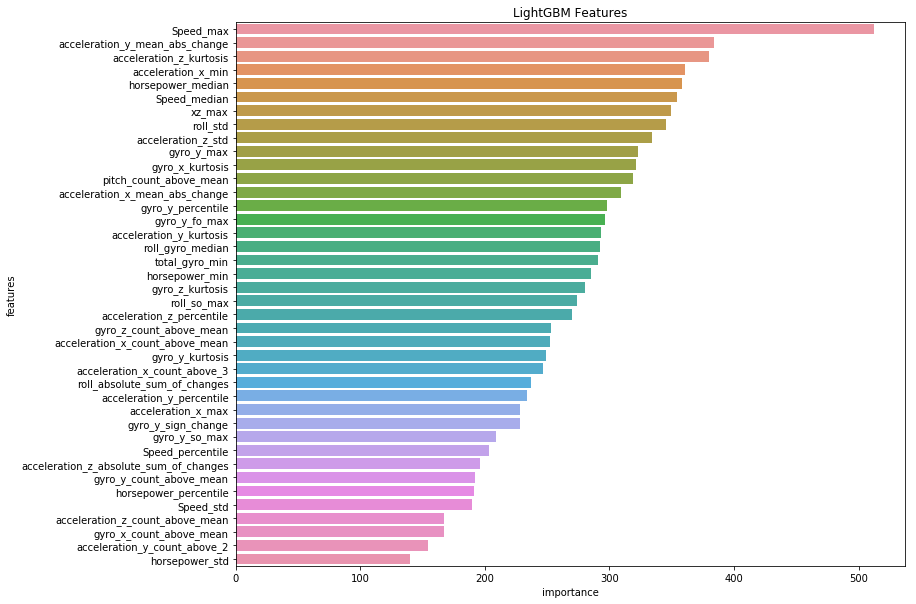

In [16]:
# ran model, set flag to true
run_model = True        

# only plot feature importance 
# for final run
if len(features_df) < 42:
    plt.figure(figsize=(12,10))
    sns.barplot(x="importance", y="features", 
                data=features_df)
    plt.title('LightGBM Features')
    plt.savefig('40_features.png')
    plt.show()

# retain top half important features
if (len(features) > 20):
    features_df = features_df[:int(len(features)/2)]

## Observations
### Leak features
`max_second` happens to be the most predictive variable to whether is a trip safe or dangerous. This "feature" should be considered as "noise" since its main function is to record each trip session in order. Removing this "feature" reduces the ROC-AUC from 0.720 to 0.680. This led me to suspect that Grab has taken more readings for each trip confirm whether is a trip dangerous.

For the sake of running the final model and submitting the final prediction, I also removed `count_second`, the number of sessions recorded for each `bookingID` since this should also be regarded as noise.

Plot can be regenerated with the code below but is left out for submission.

### Top 3 importance features
Looking at the feature importance plot by `lightgbm`, the most predictive feature is `Speed_max`, which makes sense since driving at a higher speed indicates driving more dangerously. 
Second feature is the `acceleration_y_mean_abs_change`, which is the mean of all absolute changes in `acceleration_y`.
Third feature is `acceleration_z_kurtosis`, which is the "tailedness" of `acceleration_z`.

In [0]:
# # show the leaked feature
# if not run_model:
#     leak_ = features_df[:10]
#     plt.figure(figsize=(8,6))
#     sns.barplot(x="importance", y="features", 
#                 data=leak_)
#     plt.title('LightGBM Features with leak')
#     plt.savefig('leak_.png')
#     plt.show()

## Submission

In [0]:
# # UNCOMMENT
# submit predictions
# oof_test.to_csv(f'{PATH_FEATURES}/submission.csv')

## Model 2
### Generalized Additive Model
Run `pygam`. Start by selecting smoothing parameters `lam` by doing a `random grid search`.

In [0]:
# ==================
# scale the features
# ==================
s = StandardScaler()

X = s.fit_transform(train_df[features].values)
y = train_df['label'].values

In [0]:
# ==================
# random search for  
# smoothing parameters (lambda)
# code from pygam's documentation
# ==================
np.random.seed(0)
lams = np.random.rand(5, len(features))
lams = lams * 8 - 3 # shift values to -3, 3
lams = np.exp(lams) 

In [21]:
# ==================
# fit the model
# ==================
%%time
gam = LogisticGAM().gridsearch(X, y, 
                               lam=lams,
                               keep_best=True)

100% (5 of 5) |##########################| Elapsed Time: 0:02:38 Time:  0:02:38


CPU times: user 4min 25s, sys: 25.5 s, total: 4min 50s
Wall time: 2min 38s


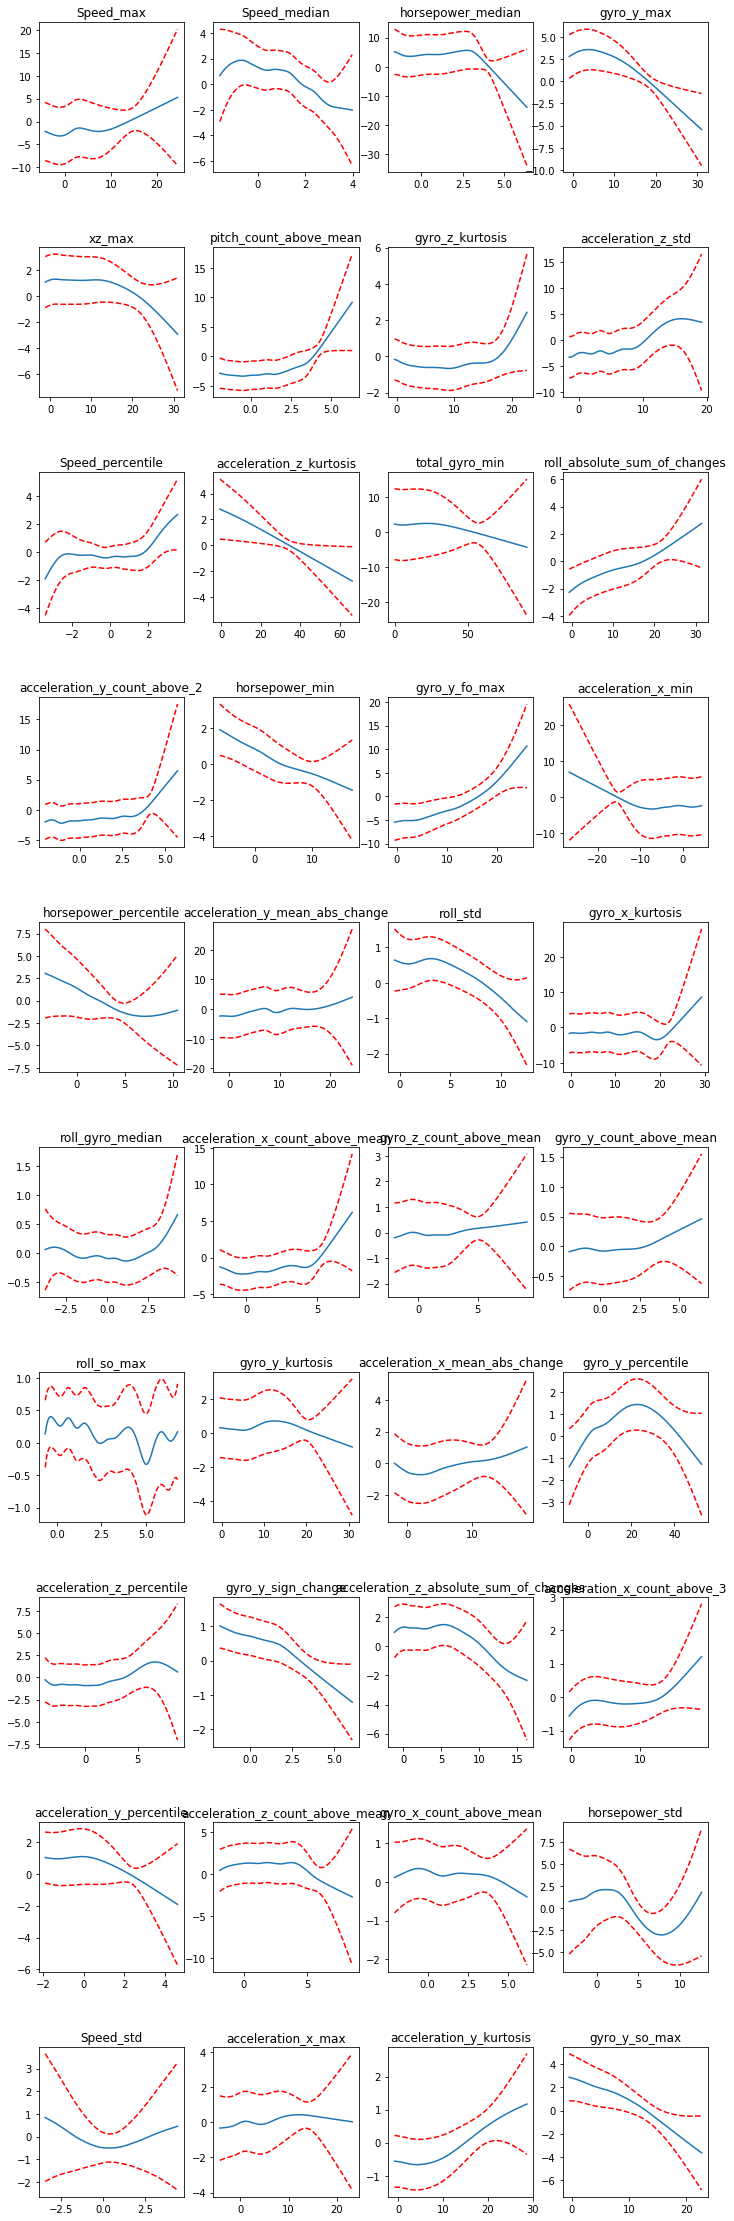

In [22]:
# ==================
# partial dependence plot
# on all features
# ==================
plt.figure(figsize=(12,40))
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue
        
    plt.subplot(10, 4, i+1)
    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)

    plt.plot(XX[:, term.feature], pdep)
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')    
    plt.title(features[i])
    plt.subplots_adjust(hspace=0.5)
    
plt.show()

In [23]:
# ==================
# check for accuracy
# ==================
gam.accuracy(X, y)

0.770088198690547

In [24]:
# ==================
# logistic GAM statistic summary
# ==================
gam.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                    230.8365
Link Function:                        LogitLink Log Likelihood:                                 -9361.3526
Number of Samples:                        18481 AIC:                                            19184.3781
                                                AICc:                                           19190.2943
                                                UBRE:                                               3.0481
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                    0.123
Feature Function                  Lam

In [0]:
# ==================
# using the best lambdas
# found, perform KFold
# ==================
random_state = 42
np.random.seed(random_state)

folds = 4
skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=random_state)

val_aucs = []
feature_importance_df = pd.DataFrame()

oof = train_df[['bookingID', 'label']]
oof['predict'] = 0
oof = oof.reset_index()

In [26]:
%%time
for fold, (trn_idx, val_idx) in enumerate(skf.split(train_df, train_df['label'])):
  
    X_train = train_df.iloc[trn_idx][features].values
    y_train = train_df.iloc[trn_idx]['label'].values
    X_valid = train_df.iloc[val_idx][features].values
    y_valid = train_df.iloc[val_idx]['label'].values
    
    gam = LogisticGAM(lam=gam.lam).fit(X_train, y_train)        
    
    p_valid = gam.predict_proba(X_valid)
    
    # ==================
    # impute NaN with 0
    # ==================
    nans = np.where(np.isnan(p_valid))
    
    for i in nans:
        p_valid[i] = 0

    oof['predict'][val_idx] = p_valid
    val_score = roc_auc_score(y_valid, p_valid)
    
    print('fold {}\'s auc: {}'.format(fold+1, val_score))
    
    val_aucs.append(val_score)

fold 1's auc: 0.6943363047473768
fold 2's auc: 0.6787584102188523
fold 3's auc: 0.6844225273174964
fold 4's auc: 0.6762285855870318
CPU times: user 3min 16s, sys: 19.6 s, total: 3min 35s
Wall time: 1min 58s


In [27]:
mean_auc = np.mean(val_aucs)
std_auc = np.std(val_aucs)
all_auc = roc_auc_score(oof['label'], oof['predict'])
print("Mean auc: %.9f, std: %.9f. All auc: %.9f." % (mean_auc, std_auc, all_auc))

Mean auc: 0.683436457, std: 0.006957308. All auc: 0.683343708.


## Model 3
### XGBoost

In [0]:
random_state = 42
np.random.seed(random_state)

folds = 5
skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=random_state)

val_aucs = []
feature_importance_df = pd.DataFrame()

oof = train_df[['bookingID', 'label']]
oof['predict'] = 0
oof = oof.reset_index()

In [0]:
# ==================
# xgb params
# ==================
xgb_params = {
    'objective':'binary:logistic',
    'metric': 'auc',
    'verbose': 1,
    'learning_rate': 0.05,
    'max_depth': 5,
    "seed": random_state
}

In [30]:
len(features)

40

In [31]:
%%time
for fold, (trn_idx, val_idx) in enumerate(skf.split(train_df, train_df['label'])):
    X_train, y_train = train_df.iloc[trn_idx][features], train_df.iloc[trn_idx]['label']
    X_valid, y_valid = train_df.iloc[val_idx][features], train_df.iloc[val_idx]['label']
    
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_valid, label=y_valid)
        
    xgb_clf = xgb.train(xgb_params,
                        dtrain,
                        5000,
                        evals=[(dtrain, 'train'), (dtest, 'valid')],
                        early_stopping_rounds=100,
                        verbose_eval=100)

    p_valid = xgb_clf.predict(dtest,
                              ntree_limit=xgb_clf.best_ntree_limit)

    oof['predict'][val_idx] = p_valid
    val_score = roc_auc_score(y_valid, p_valid)
    val_aucs.append(val_score)

[0]	train-error:0.232887	valid-error:0.239383
Multiple eval metrics have been passed: 'valid-error' will be used for early stopping.

Will train until valid-error hasn't improved in 100 rounds.
[100]	train-error:0.213406	valid-error:0.232351
[200]	train-error:0.196699	valid-error:0.233703
Stopping. Best iteration:
[104]	train-error:0.212865	valid-error:0.231539

[0]	train-error:0.232465	valid-error:0.24026
Multiple eval metrics have been passed: 'valid-error' will be used for early stopping.

Will train until valid-error hasn't improved in 100 rounds.
[100]	train-error:0.210281	valid-error:0.237554
Stopping. Best iteration:
[7]	train-error:0.229219	valid-error:0.23539

[0]	train-error:0.233006	valid-error:0.248106
Multiple eval metrics have been passed: 'valid-error' will be used for early stopping.

Will train until valid-error hasn't improved in 100 rounds.
[100]	train-error:0.210078	valid-error:0.239448
Stopping. Best iteration:
[23]	train-error:0.223132	valid-error:0.238636

[0]	tr

In [32]:
mean_auc = np.mean(val_aucs)
std_auc = np.std(val_aucs)
all_auc = roc_auc_score(oof['label'], oof['predict'])
print("Mean auc: %.9f, std: %.9f. All auc: %.9f." % (mean_auc, std_auc, all_auc))

Mean auc: 0.678862264, std: 0.008579621. All auc: 0.647688196.


## Interpretation
Understanding each feature from the best  model, `lightgbm` using `shap`.

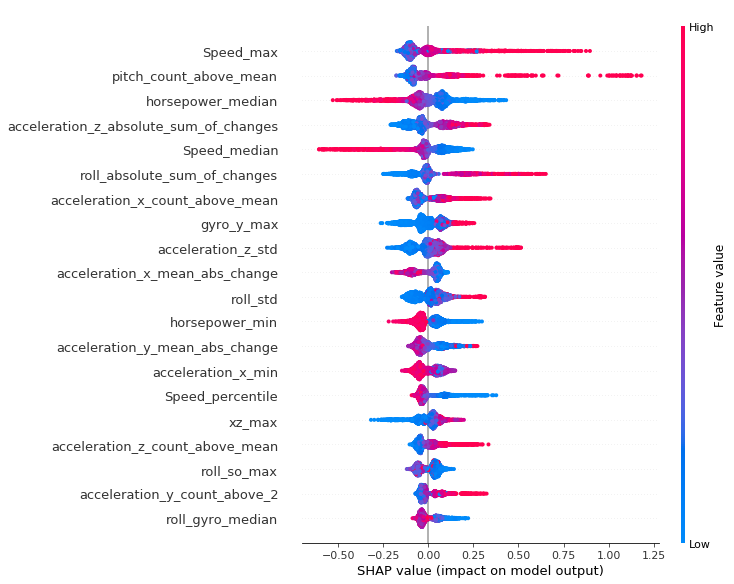

In [33]:
shap_values = shap.TreeExplainer(lgb_clf).shap_values(X_valid)

shap.summary_plot(shap_values, X_valid)

Draw partial depedence plot for the top 10 features.

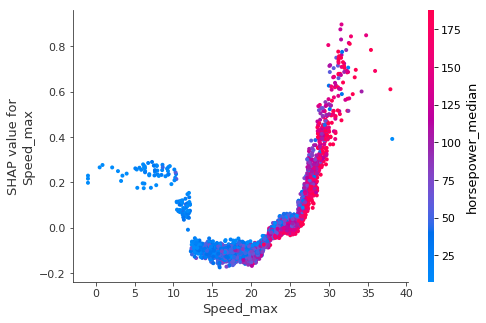

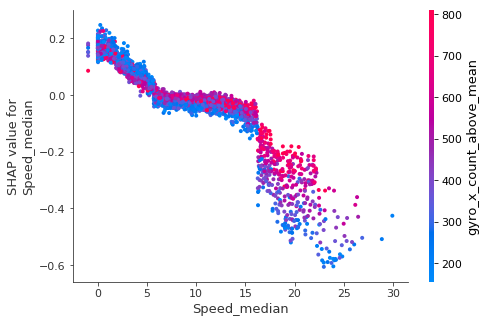

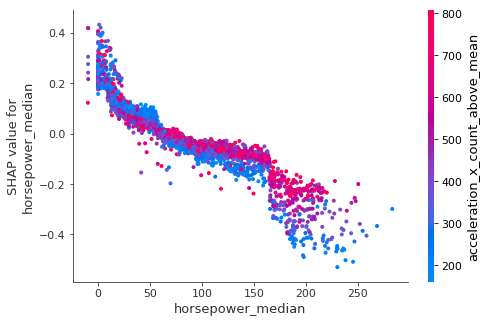

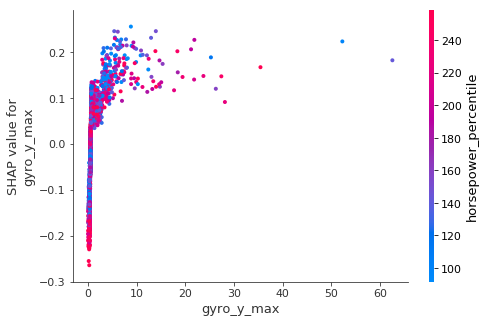

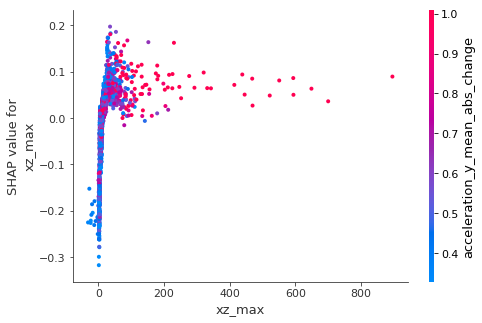

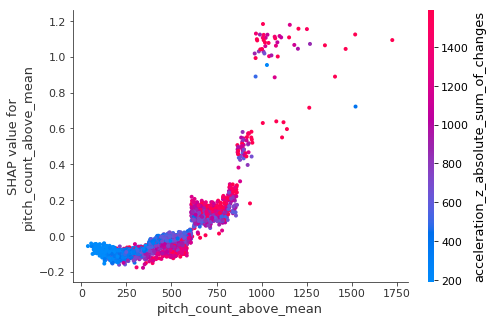

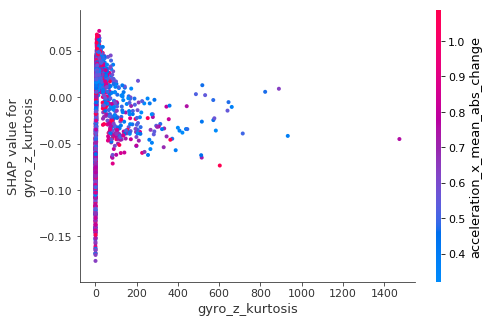

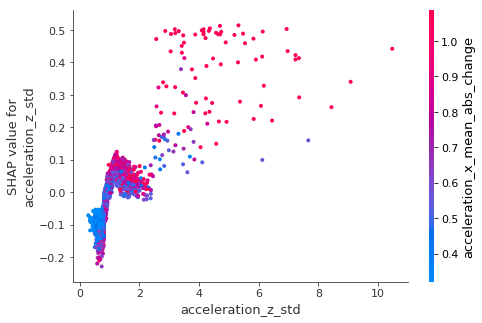

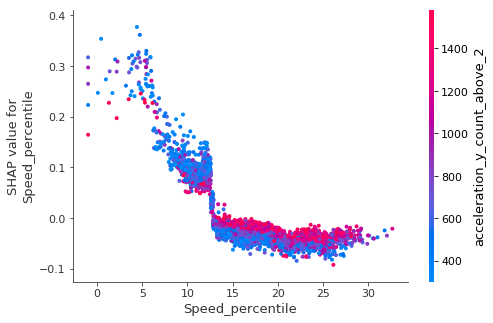

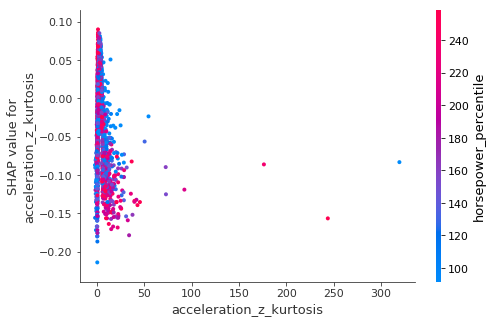

In [34]:
for f in features[:10]:
    shap.dependence_plot(f, shap_values, X_valid)

In [0]:
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

Confusion matrix, without normalization


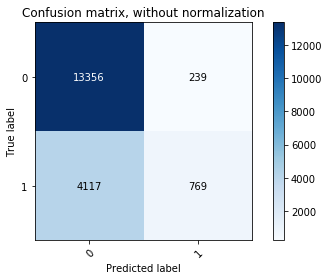

In [36]:
predict_bin = (oof['predict'] > 0.5).astype(int)

# Plot non-normalized confusion matrix
plot_confusion_matrix(oof['label'], predict_bin, classes = np.array([0, 1]),
                      title='Confusion matrix, without normalization')

# # Plot normalized confusion matrix
# plot_confusion_matrix(oof['label'], predict_bin, classes = np.array([0, 1]),
#                       normalize=True,
#                       title='Confusion matrix, with normalization')

plt.show()

## What did not work
### Local Outlier Factor

Hypothesis: Outliers in certain readings are most important to predicting whether is a trip dangerous. With that in mind, I tried applying the `LocalOutlierFactor` algorithm from `sklearn` but was not successful.

### Logistic Regression
AUC-ROC was around 0.57.